In [1]:
from rasterstats import zonal_stats
from multiprocessing import Pool
import pandas as pd
import numpy as np

import geopandas as gpd

# after several trials, found that the nuts2 code used by EUROSTAT is 2013 version
nuts = gpd.read_file('/mnt/inca/tillage_index/validate_data/EUROSTATS/nuts2/NUTS_RG_20M_2013_3035.shp')
nuts = nuts.loc[nuts['LEVL_CODE']==2]
# nuts = nuts.drop(columns=['MOUNT_TYPE', 'URBN_TYPE', 'COAST_TYPE','NUTS_NAME','LEVL_CODE'])

## organize the eurostats first
- crop rotation
- tillage
- soil cover

In [42]:
# https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Glossary:Crop_rotation

df = pd.read_csv('/mnt/inca/tillage_index/validate_data/EUROSTATS/ef_mp_soil_linear.csv')
df = df.loc[(df['soil_cov']=='ARA') & (df['farmtype']=='TOTAL') & (df['unit']=='HA') & (df['agrarea']=='TOTAL')]

rot = pd.DataFrame(columns = ['time', 'nuts_id', 'PC0', 'PC1-24', 'PC25-49', 'PC50-74', 'PC_GE75', 'NAP', 'TOTAL'])

# organize separate entries into the same row according to nuts2 id, drop imcomplete datasets
for i in df['geo'].unique().tolist():
    
    temp = df.loc[(df['geo']==i) & (df['TIME_PERIOD']==2010)]
    if len(temp)==7:
        tlist = temp.iloc[0][['TIME_PERIOD','geo']].tolist()
        for tt in ['PC0', 'PC1-24', 'PC25-49', 'PC50-74', 'PC_GE75', 'NAP', 'TOTAL']:
            tlist.append(temp.loc[temp['crop_rot']==tt]['OBS_VALUE'].values[0])
        rot.loc[len(rot)] = tlist
    
    temp = df.loc[(df['geo']==i) & (df['TIME_PERIOD']==2016)]
    if len(temp)==7:
        tlist = temp.iloc[0][['TIME_PERIOD','geo']].tolist()
        for tt in ['PC0', 'PC1-24', 'PC25-49', 'PC50-74', 'PC_GE75', 'NAP', 'TOTAL']:
            tlist.append(temp.loc[temp['crop_rot']==tt]['OBS_VALUE'].values[0])
        rot.loc[len(rot)] = tlist
print(f'organize into one row: {len(rot)}')

# correlate to get the merged final data
gdf = rot.merge(nuts, left_on='nuts_id', right_on='NUTS_ID')
gdf = gdf.rename(columns = {'NAME_LATN':'name','CNTR_CODE':'cntr_code'})
gdf = gdf.drop(columns=['NUTS_ID','FID'])
gdf = gpd.GeoDataFrame(gdf, geometry='geometry',crs=nuts.crs)

print(f'intersect with polygons: {len(gdf)}')
length_ori = len(gdf)

# remove entries with missing records
gdf = gdf.dropna(subset = ['PC0', 'PC1-24', 'PC25-49', 'PC50-74', 'PC_GE75', 'NAP'])
print(f'{length_ori-len(gdf)} entries with missing values are removed, {len(gdf)} left')

gdf.to_file('/mnt/inca/tillage_index/validate_data/001_vld_crop.rotation.shp', driver='ESRI Shapefile')

organize into one row: 200
intersect with polygons: 181
37 entries with missing values are removed, 144 left


In [33]:
# organize the EU stats data for later validation use

# get tillage data
# https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Agri-environmental_indicator_-_tillage_practices#Data_sources

# arable area sown/cultivated
# not tillagable: Multi-annual plants like temporary grassland, leguminous plants, industrial crops (hops or aromatic plants) etc. 
# were excluded from the survey and covered separately in the category 'not recorded'

tlg = pd.read_csv('/mnt/inca/tillage_index/validate_data/EUROSTATS/ef_mp_prac_linear.csv')
# get only tillage index, and aggregate all other info
tlg = tlg.loc[(tlg['farmtype']=='TOTAL') & (tlg['agrarea']=='TOTAL') & (tlg['unit']=='HA') & (tlg['crop_rot']=='TOTAL')].reset_index()

dff = pd.DataFrame(columns = ['time', 'nuts_id', 'ARA', 'ARAXTIL', 'TIL_CSERV', 'TIL_CV', 'TIL_ZERO'])
for i in tlg['geo'].unique().tolist():
    temp = tlg.loc[(tlg['geo']==i) & (tlg['TIME_PERIOD']==2010)]
    if len(temp)==5:
        tlist = temp.iloc[0][['TIME_PERIOD','geo']].tolist()
        for tt in ['ARA', 'ARAXTIL', 'TIL_CSERV', 'TIL_CV', 'TIL_ZERO']:
            tlist.append(temp.loc[temp['tillage']==tt]['OBS_VALUE'].values[0])
        dff.loc[len(dff)] = tlist
    
    temp = tlg.loc[(tlg['geo']==i) & (tlg['TIME_PERIOD']==2016)]
    if len(temp)==5:
        tlist = temp.iloc[0][['TIME_PERIOD','geo']].tolist()
        for tt in ['ARA', 'ARAXTIL', 'TIL_CSERV', 'TIL_CV', 'TIL_ZERO']:
            tlist.append(temp.loc[temp['tillage']==tt]['OBS_VALUE'].values[0])
        dff.loc[len(dff)] = tlist
    
print(f'organize into one row: {len(dff)}')

# correlate to get the merged final data
gdf = dff.merge(nuts, left_on='nuts_id', right_on='NUTS_ID')
gdf = gdf.rename(columns = {'NAME_LATN':'name','CNTR_CODE':'cntr_code'})
gdf = gdf.drop(columns=['NUTS_ID','FID'])
gdf = gpd.GeoDataFrame(gdf, geometry='geometry',crs=nuts.crs)
length_ori = len(gdf)
print(f'intersect with polygons: {len(gdf)}')
    
# remove entries with missing records
gdf = gdf.dropna(subset = ['ARAXTIL', 'TIL_CSERV', 'TIL_CV', 'TIL_ZERO'])
print(f'{length_ori-len(gdf)} entries with missing values are removed, {len(gdf)} left')

gdf.to_file('/mnt/inca/tillage_index/validate_data/002_vld_tillage.shp', driver='ESRI Shapefile')

organize into one row: 337
intersect with polygons: 298
12 entries with missing values are removed, 286 left


In [41]:
# https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Glossary:Soil_cover

df = pd.read_csv('/mnt/inca/tillage_index/validate_data/EUROSTATS/ef_mp_soil_linear.csv')
df = df.loc[(df['crop_rot']=='TOTAL') & (df['farmtype']=='TOTAL') & (df['unit']=='HA') & (df['agrarea']=='TOTAL')]

scov = pd.DataFrame(columns = ['time', 'nuts_id', 'ARA', 'ARAXSC', 'BARE', 'COV_INTCR', 'MAPL', 'PLRES', 'WNTCR'])

# organize separate entries into the same row according to nuts2 id, drop imcomplete datasets
for i in df['geo'].unique().tolist():
    
    temp = df.loc[(df['geo']==i) & (df['TIME_PERIOD']==2010)]
    if len(temp)==7:
        tlist = temp.iloc[0][['TIME_PERIOD','geo']].tolist()
        for tt in ['ARA', 'ARAXSC', 'SC_BARE', 'SC_COV_INTCR', 'SC_MAPL', 'SC_PLRES', 'SC_WNTCR']:
            tlist.append(temp.loc[temp['soil_cov']==tt]['OBS_VALUE'].values[0])
        scov.loc[len(scov)] = tlist
    
    temp = df.loc[(df['geo']==i) & (df['TIME_PERIOD']==2016)]
    if len(temp)==7:
        tlist = temp.iloc[0][['TIME_PERIOD','geo']].tolist()
        for tt in ['ARA', 'ARAXSC', 'SC_BARE', 'SC_COV_INTCR', 'SC_MAPL', 'SC_PLRES', 'SC_WNTCR']:
            tlist.append(temp.loc[temp['soil_cov']==tt]['OBS_VALUE'].values[0])
        scov.loc[len(scov)] = tlist
print(f'organize into one row: {len(scov)}')

# correlate to get the merged final data
gdf = scov.merge(nuts, left_on='nuts_id', right_on='NUTS_ID')
gdf = gdf.rename(columns = {'NAME_LATN':'name','CNTR_CODE':'cntr_code'})
gdf = gdf.drop(columns=['NUTS_ID','FID'])
gdf = gpd.GeoDataFrame(gdf, geometry='geometry',crs=nuts.crs)

print(f'intersect with polygons: {len(gdf)}')
length_ori = len(gdf)

# remove entries with missing records
gdf = gdf.dropna(subset = ['ARAXSC', 'BARE', 'COV_INTCR', 'MAPL', 'PLRES', 'WNTCR'])
print(f'{length_ori-len(gdf)} entries with missing values are removed, {len(gdf)} left')

gdf.to_file('/mnt/inca/tillage_index/validate_data/003_vld_soil.cover.shp', driver='ESRI Shapefile')

organize into one row: 241
intersect with polygons: 218
10 entries with missing values are removed, 208 left


## overlay with corresponding index layer
- crop rotation, NOS
- tillage, NDTI
- soil cover, BSF

### remove the non-arable pixels

In [2]:
# remove the non-arable pixels
from eumap.misc import find_files, nan_percentile, ttprint
from eumap.raster import read_rasters, save_rasters
from eumap.parallel import TilingProcessing

# rot = gpd.read_file('/mnt/inca/tillage_index/validate_data/001_vld_crop.rotation.shp')
tlg = gpd.read_file('/mnt/inca/tillage_index/validate_data/002_vld_tillage.shp')
# cov = gpd.read_file('/mnt/inca/tillage_index/validate_data/003_vld_soil.cover.shp')
src = ['http://192.168.49.30:8333/ai4sh/nos/nos_glad.landsat.seasconv_m_30m_s_20160101_20161231_eu_epsg.3035_v20231127.tif',
       'http://192.168.49.30:8333/ai4sh/bs/bs_glad.landsat.seasconv.m.yearly_sum_30m_s_20160101_20161231_eu_epsg.3035_v20231127.tif',
       'http://192.168.49.30:8333/ai4sh/ndti.min/ndti.min_glad.landsat.ard2.seasconv.bimonthly.min_m_30m_s_20100101_20101231_eu_epsg.3035_v20231218.tif',
       'http://192.168.49.30:8333/ai4sh/ndti.min/ndti.min_glad.landsat.ard2.seasconv.bimonthly.min_m_30m_s_20160101_20161231_eu_epsg.3035_v20231218.tif']
tgt = ['/mnt/inca/tillage_index/validate_data/nos_2016.tif',
       '/mnt/inca/tillage_index/validate_data/bs_2016.tif',
       '/mnt/inca/tillage_index/validate_data/min.ndti_2010.tif',
       '/mnt/inca/tillage_index/validate_data/min.ndti_2016.tif']



In [5]:
mask_file = '/mnt/inca/tillage_index/validate_data/EUROSTATS/EUCROPMAP_2018_crop.mask.tif'
mask, _ = read_rasters(raster_files=[mask_file], n_jobs=60)

In [4]:
i = 0
data, _ = read_rasters(raster_files=[src[i]], n_jobs=60)
data[(np.squeeze(mask)//100)!=2, :] = 255
save_rasters(src[i], [tgt[i]], data, n_jobs=60)

/tmp/ipykernel_231/2638260024.py:3: RuntimeWarning: invalid value encountered in floor_divide
  data[(np.squeeze(mask)//100)!=2, :] = 255


['/mnt/inca/tillage_index/validate_data/nos_2016.tif']

In [5]:
i = 1
data, _ = read_rasters(raster_files=[src[i]], n_jobs=60)
data[(np.squeeze(mask)//100)!=2, :] = 255
save_rasters(src[i], [tgt[i]], data, n_jobs=60)

/tmp/ipykernel_231/672789908.py:3: RuntimeWarning: invalid value encountered in floor_divide
  data[(np.squeeze(mask)//100)!=2, :] = 255


['/mnt/inca/tillage_index/validate_data/bs_2016.tif']

In [7]:
i = 2
data, _ = read_rasters(raster_files=[src[i]], n_jobs=60)
data[(np.squeeze(mask)//100)!=2, :] = 255
save_rasters(src[i], [tgt[i]], data, n_jobs=60)

/tmp/ipykernel_4122/1752231291.py:3: RuntimeWarning: invalid value encountered in floor_divide
  data[(np.squeeze(mask)//100)!=2, :] = 255


['/mnt/inca/tillage_index/validate_data/min.ndti_2010.tif']

In [8]:
i = 3
data, _ = read_rasters(raster_files=[src[i]], n_jobs=60)
data[(np.squeeze(mask)//100)!=2, :] = 255
save_rasters(src[i], [tgt[i]], data, n_jobs=60)

/tmp/ipykernel_4122/3678319269.py:3: RuntimeWarning: invalid value encountered in floor_divide
  data[(np.squeeze(mask)//100)!=2, :] = 255


['/mnt/inca/tillage_index/validate_data/min.ndti_2016.tif']

### now overlay

In [1]:
from rasterstats import zonal_stats
from multiprocessing import Pool
import pandas as pd
import numpy as np
import rasterio
import geopandas as gpd
# organize the stats
stats = ['count', 'mean', 'std', 'median', 'percentile_90', 'percentile_10']

# def calculate_zonal_stats(args):
#     index, geometry, stats, t, raster_path = args

#     # Calculate the standard zonal statistics
#     result = zonal_stats(geometry, raster_path, stats=stats)[0]

#     # Open the raster file and read the values for the specified geometry
#     with rasterio.open(raster_path) as src:
#         # Convert geometry into a format that rasterio can use (from GeoJSON-like dict to a shape)
#         if isinstance(geometry, gpd.GeoDataFrame):
#             geometry = geometry.__geo_interface__
#         elif isinstance(geometry, gpd.GeoSeries):
#             geometry = geometry.values[0].__geo_interface__

#         # Create a mask for the geometry
#         out_image, out_transform = rasterio.mask.mask(src, [geometry], crop=True)
#         # Count the pixels with value 0
#         count_zero = (out_image == 0).sum()

#         # Add this count to the result
#         result['count_zero'] = count_zero

#     return index, result

# import numpy as np

def calculate_zonal_stats(args):
    index, geometry, stats, t, raster_path = args
#     print(raster_path)

    # Initialize the result dictionary with NaNs for each statistic
    result = {stat: np.nan for stat in stats}
    result['count_zero'] = np.nan  # Include count_zero in the initialized results

    try:
        # Calculate the standard zonal statistics
        zonal_result = zonal_stats(geometry, raster_path, stats=stats)
        if zonal_result:
            result.update(zonal_result[0])

        # Open the raster file and read the values for the specified geometry
        with rasterio.open(raster_path) as src:
            # Convert geometry into a format that rasterio can use (from GeoJSON-like dict to a shape)
            if isinstance(geometry, gpd.GeoDataFrame):
                geometry = geometry.__geo_interface__
            elif isinstance(geometry, gpd.GeoSeries):
                geometry = geometry.values[0].__geo_interface__

            # Create a mask for the geometry
            out_image, out_transform = rasterio.mask.mask(src, [geometry], crop=True)
            # Count the pixels with value 0
            count_zero = (out_image == 0).sum()

            # Add this count to the result
            result['count_zero'] = count_zero

    except ValueError as e:
        # Handle cases where the geometry does not overlap with the raster
        print(f"Error for index {index}: {e}")

    return index, result


In [3]:
tlg = tlg.drop(columns=['count', 'mean', 'std',
       'median', 'p90', 'p10', 'count_zero', 'sum', 'share_xld', 'share_cser',
       'share_cv', 'share_zero', 'score'])

In [4]:
for year in tlg['time'].unique():
    tlg_tmp = tlg.loc[tlg['time']==year]
    args = [(index, row.geometry, stats, row['time'], f'/mnt/inca/tillage_index/validate_data/min.ndti_{year}.tif') for index, row in tlg_tmp.iterrows()]
    print(year, len(tlg_tmp))
    
    with Pool(60) as pool:
        results = pool.map(calculate_zonal_stats, args)
        
    sorted_results = sorted(results, key=lambda x: x[0])
    sorted_results = [result for index, result in sorted_results]
    results_df = pd.DataFrame(sorted_results, index=tlg_tmp.index)
    
    tlg_tmp = tlg_tmp.merge(results_df, left_index=True, right_index=True)
    print(len(tlg_tmp))
    
    tlg_tmp = tlg_tmp.rename(columns={'percentile_10':'p10','percentile_90':'p90'})
    tlg_tmp.to_file(f'/mnt/inca/tillage_index/validate_data/002_tmp.vld_tillage.{year}.shp', driver='ESRI Shapefile')

2010 77
77
2016 202
202


In [5]:
tlg1 = gpd.read_file('/mnt/inca/tillage_index/validate_data/002_tmp.vld_tillage.2010.shp')
tlg2 = gpd.read_file('/mnt/inca/tillage_index/validate_data/002_tmp.vld_tillage.2016.shp')

tlg = pd.concat([tlg1,tlg2])
tlg.to_file(f'/mnt/inca/tillage_index/validate_data/002_vld_tillage.shp', driver='ESRI Shapefile')

In [39]:
# import rasterio

# args = [(index, row.geometry, stats, row['time'], tgt[1]) for index, row in cov.iterrows()]
# print(len(cov))

# with Pool(60) as pool:
#     results = pool.map(calculate_zonal_stats, args)

# sorted_results = sorted(results, key=lambda x: x[0])
# sorted_results = [result for index, result in sorted_results]
# results_df = pd.DataFrame(sorted_results, index=cov.index)

# cov = cov.merge(results_df, left_index=True, right_index=True)
# print(len(cov))
# cov = cov.rename(columns={'percenti_10':'p10','percentile_90':'p90'})
# # cov.to_file('/mnt/inca/tillage_index/validate_data/003_vld_soil.cover.shp', driver='ESRI Shapefile')

## check, visualize, validate

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
# rot = gpd.read_file('/mnt/inca/tillage_index/validate_data/001_vld_crop.rotation.shp')
# cov = gpd.read_file('/mnt/inca/tillage_index/validate_data/003_vld_soil.cover.shp')
# ∑ (conventional tillage + conservation tillage + zero tillage) = arable land – arable land not sown/cultivated during the reference year. 

tlg = gpd.read_file('/mnt/inca/tillage_index/data/002_vld_tillage.shp')
name_map = dict(zip(['share_cv', 'share_cser', 'share_zero', 'share_xld'],['share of TIL_CV', 'share of TIL_CSERV', 'share of TIL_ZERO', 'share of ARAXTIL']))
tlg = tlg.rename(columns=name_map)

# tlg = tlg.drop(columns=['sum', 'share_xld', 'share_cser', 'share_cv', 'share_zero'])

# tlg['sum'] = 0
# for iii in ['til_cserv', 'til_cv', 'til_zero']:
#     tlg['sum'] = tlg['sum'] + tlg[iii]
# for iii in ['araxtil', 'til_cserv', 'til_cv', 'til_zero']: #'araxtil', 
#     tlg[f'share_{iii}'] = tlg[iii]/tlg['sum']
# tlg = tlg.dropna(subset=['araxtil', 'til_cserv', 'til_cv', 'til_zero','mean'])
# tlg = tlg.rename(columns={'araxtil':'share_xld','share_til_cserv':'share_cser','share_til_cv':'share_cv','share_til_zero':'share_zero'})

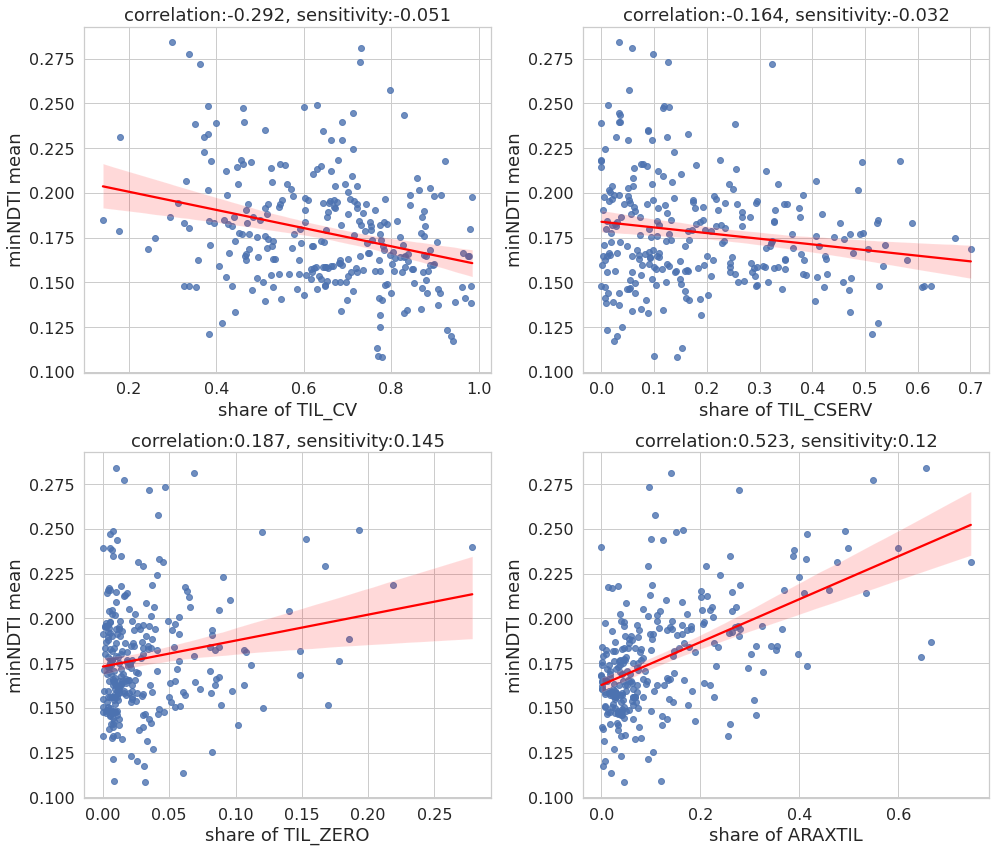

In [9]:
# Sensitivity analysis
import statsmodels.api as sm
tlg['mean_scaled'] = (tlg['mean']-125)*0.008
corre = pd.DataFrame()
corre['tillage_practice'] = ['share of TIL_CV', 'share of TIL_CSERV', 'share of TIL_ZERO', 'share of ARAXTIL']
corr = []
regr_cof = []
r2 = []
y = tlg['mean_scaled'].values
for column in ['share of TIL_CV', 'share of TIL_CSERV', 'share of TIL_ZERO', 'share of ARAXTIL']: #, 'share_xld'
    X_individual = sm.add_constant(tlg[[column]])  # Independent variable with constant
    model_individual = sm.OLS(y, X_individual).fit()  # Fit model
    regr_cof.append(model_individual.params[1])  # Get the coefficient
    corr.append(np.corrcoef(tlg['mean_scaled'], tlg[column])[0, 1])
    r2.append(model_individual.rsquared)
     
corre['regression_slope'] = regr_cof
corre['pearson_coeffcient'] = corr
corre['regression_r2'] = r2
                


import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for i, column in enumerate(['share of TIL_CV', 'share of TIL_CSERV', 'share of TIL_ZERO', 'share of ARAXTIL']): #
    sns.regplot(x=column, y='mean_scaled', data=tlg, ax=axes[i//2, i%2], line_kws={"color": "red"})
#     sns.scatterplot(x=column, y='mean_scaled', data=tlg, hue='clm_zone',ax=axes[i//2, i%2], palette='deep')
    corr = round(corre.loc[corre['tillage_practice']==column,'pearson_coeffcient'].tolist()[0],3)
    sens = round(corre.loc[corre['tillage_practice']==column,'regression_slope'].tolist()[0],3)
    axes[i//2, i%2].set_title(f'correlation:{corr}, sensitivity:{sens}',fontsize=18) #minNDTI mean - {column}\n
    axes[i//2, i%2].set_ylabel(f'minNDTI mean',fontsize=18)
    axes[i//2, i%2].set_xlabel(column,fontsize=18)
    axes[i//2, i%2].tick_params(labelsize=16)

plt.tight_layout()
plt.savefig('/mnt/inca/tillage_index/qgis_visualization/10_vld_ndti.individual.png')

plt.show()


[28.59335998 30.         97.82577949 75.15457658] 0.5740827467519675


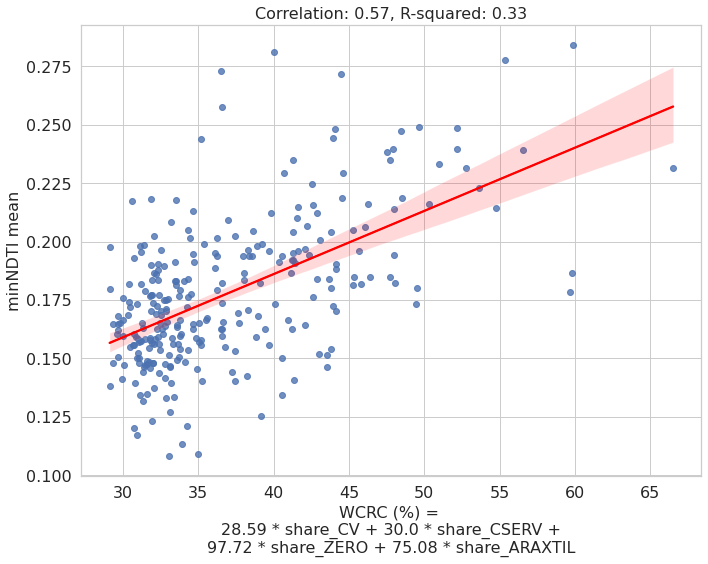

In [10]:
# # Multivariate analysis
# X_no_interaction = tlg[['share_cser', 'share_xld', 'share_zero']] #tlg['share_cser'] + tlg['share_xld'] + tlg['share_zero']
# X_no_interaction = sm.add_constant(X_no_interaction)

# model = sm.OLS(tlg['mean_scaled'], sm.add_constant(X_no_interaction)).fit()
# model_summary = model.summary()
# model_summary

# Weighted CRC
['share of TIL_CV', 'share of TIL_CSERV', 'share of TIL_ZERO', 'share of ARAXTIL']
from scipy.optimize import minimize

def negative_correlation(weights, tlg):
    weighted_sum = (tlg['share of TIL_CV'] * weights[0] +
                    tlg['share of TIL_CSERV'] * weights[1] +
                    tlg['share of TIL_ZERO'] * weights[2] + tlg['share of ARAXTIL'] * weights[3]) # 
    corr = tlg['mean_scaled'].corr(weighted_sum)
    return -corr  # Negative because the optimizer minimizes the function

initial_weights = [10, 50, 80, 50] #, 50
# bounds = [(0, 100), (0, 100), (0, 100), (0, 100)]
bounds = [(0, 30), (30, 70), (70, 100), (0, 100)] #
result = minimize(negative_correlation, initial_weights, args=(tlg,), bounds=bounds)

optimal_weights = result.x
max_correlation = -result.fun

print(optimal_weights, max_correlation)

def create_weighted_score(data, weights):
    return (data['share of TIL_CV'] * weights[0] +
            data['share of TIL_CSERV'] * weights[1] +
            data['share of TIL_ZERO'] * weights[2] + data['share of ARAXTIL'] * weights[3]) # 

import statsmodels.api as sm
tlg['weighted_crc'] = create_weighted_score(tlg, optimal_weights)
correlation_coefficient = tlg['mean_scaled'].corr(tlg['weighted_crc'])
X = sm.add_constant(tlg['weighted_crc'])
model = sm.OLS(tlg['mean_scaled'], X).fit()
r_squared = model.rsquared

slope = model.params['weighted_crc']
intercept = model.params['const']

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.regplot(x='weighted_crc', y='mean_scaled', data=tlg, line_kws={"color": "red"})
# sns.scatterplot(x='weighted_crc', y='mean_scaled', data=tlg, hue='cntr_code', palette='deep')
sns.lineplot(x=tlg['weighted_crc'], y=tlg['weighted_crc'] * slope + intercept, color='red')  # Replace 'slope' and 'intercept' with your actual values
plt.title(f'Correlation: {correlation_coefficient:.2f}, R-squared: {r_squared:.2f}',fontsize=16) #Weighted crop residue cover (CRC) vs. Mean minNDTI\n 
plt.xlabel('WCRC (%) = \n28.59 * share_CV + 30.0 * share_CSERV +\n97.72 * share_ZERO + 75.08 * share_ARAXTIL',fontsize=16)
plt.ylabel('minNDTI mean',fontsize=16)
plt.tick_params(labelsize=16)
plt.tight_layout()
plt.savefig('/mnt/inca/tillage_index/qgis_visualization/11_vld_ndti.wcrc.png')

plt.show()


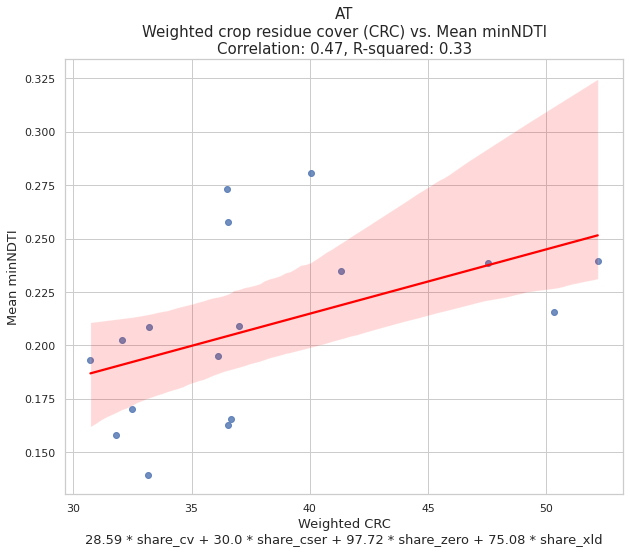

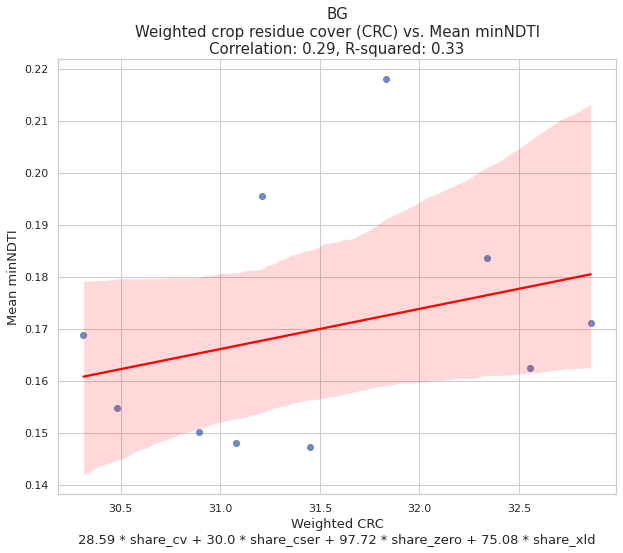

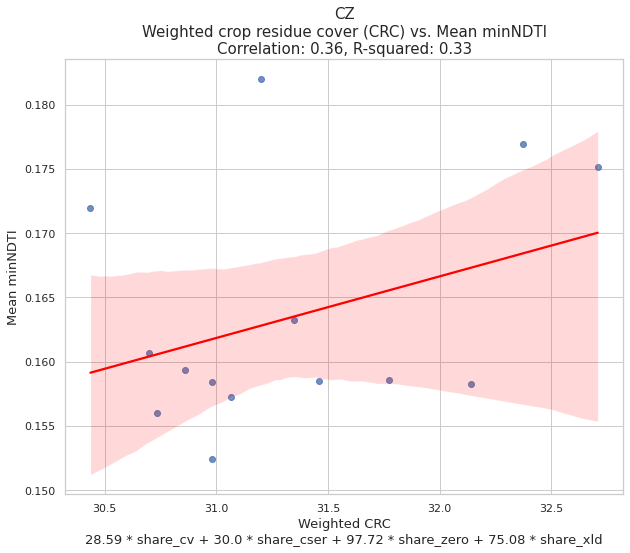

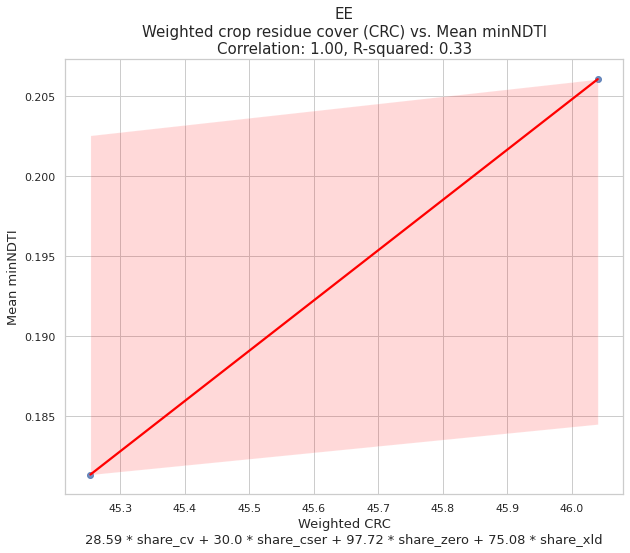

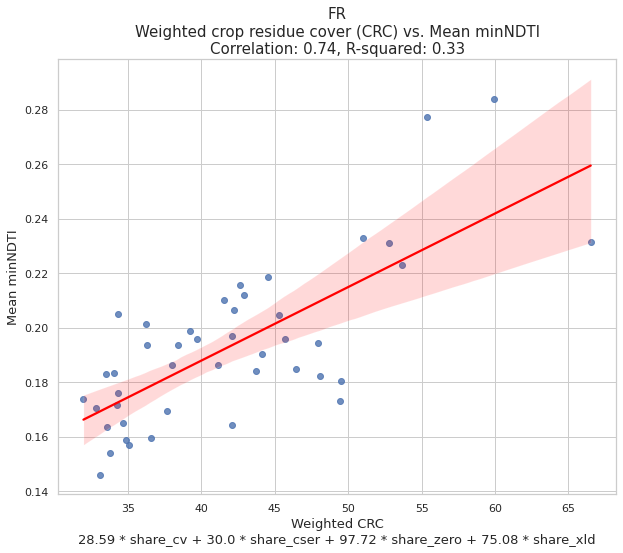

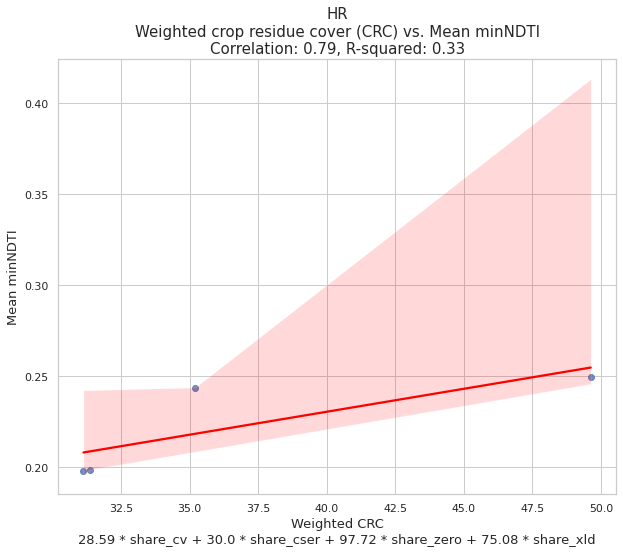

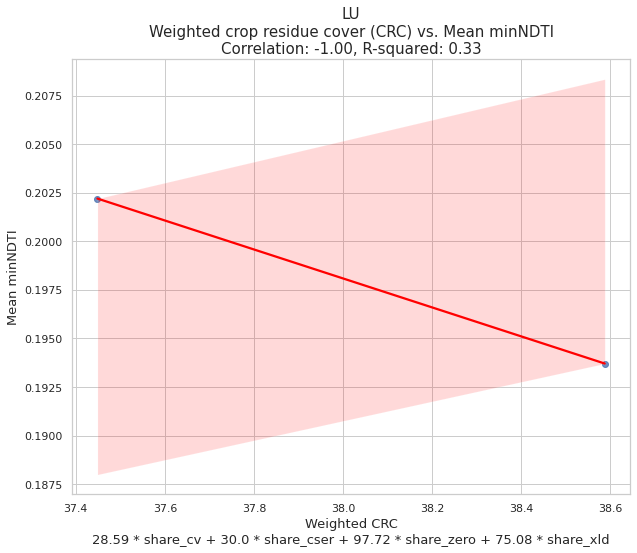

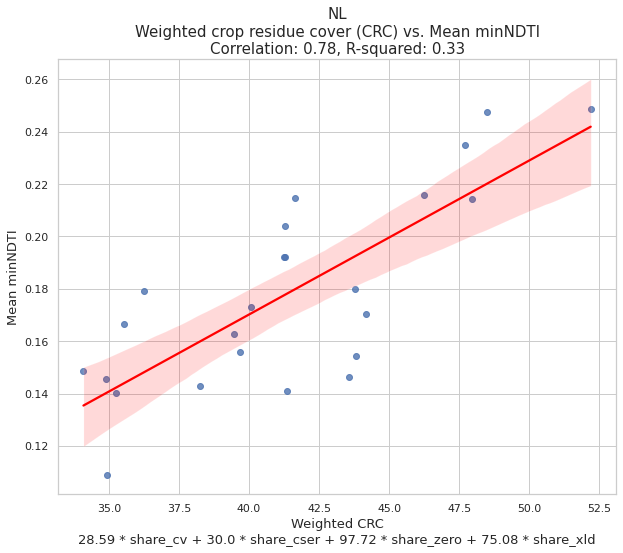

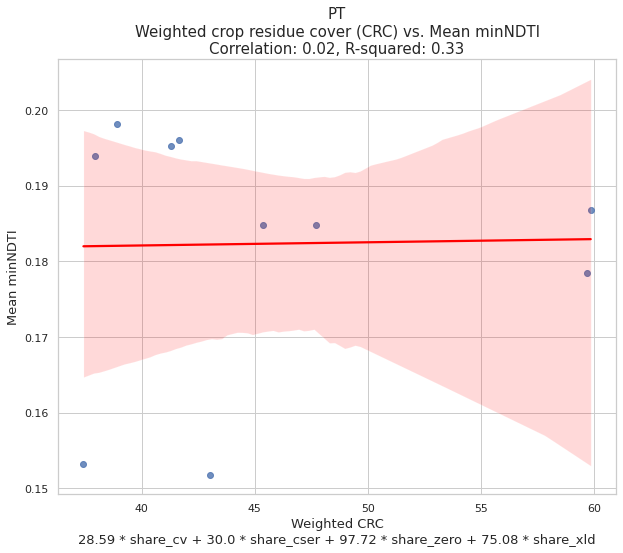

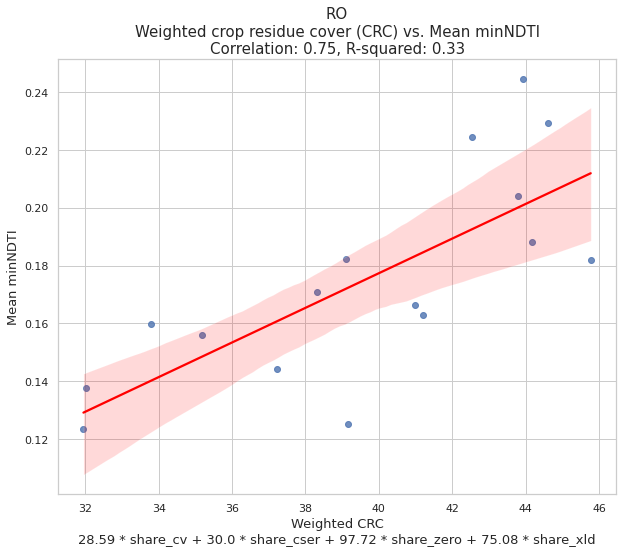

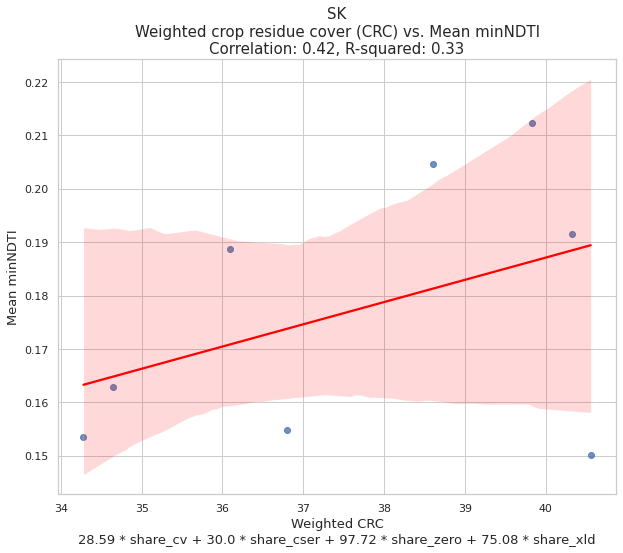

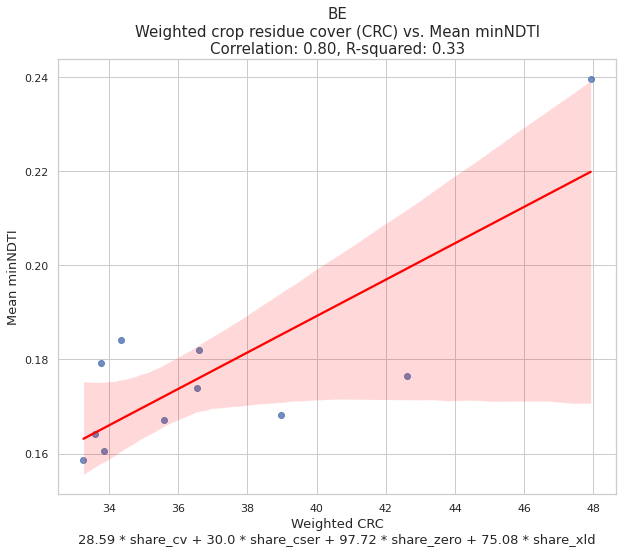

/opt/conda/lib/python3.8/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/conda/lib/python3.8/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


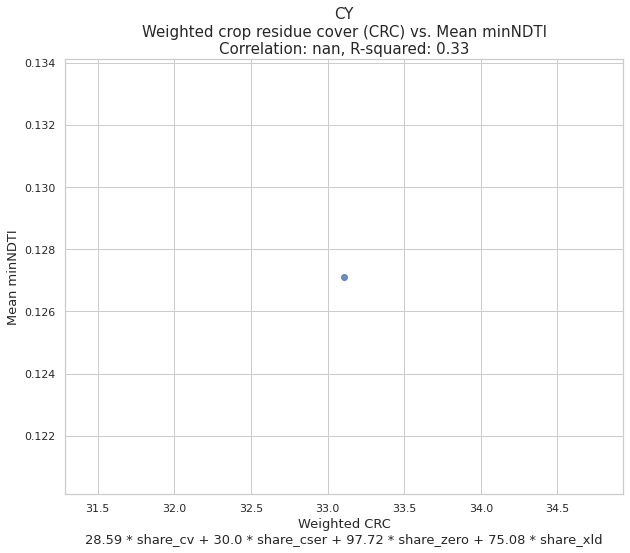

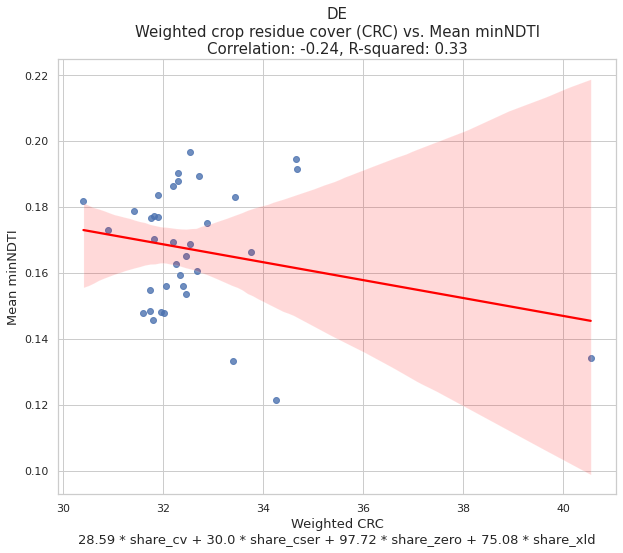

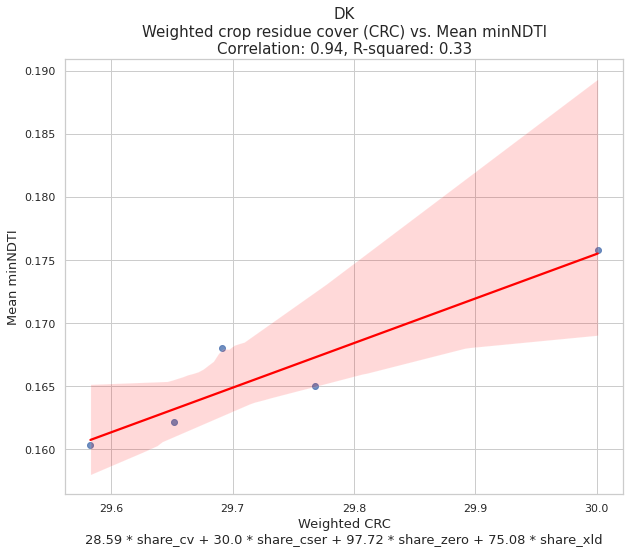

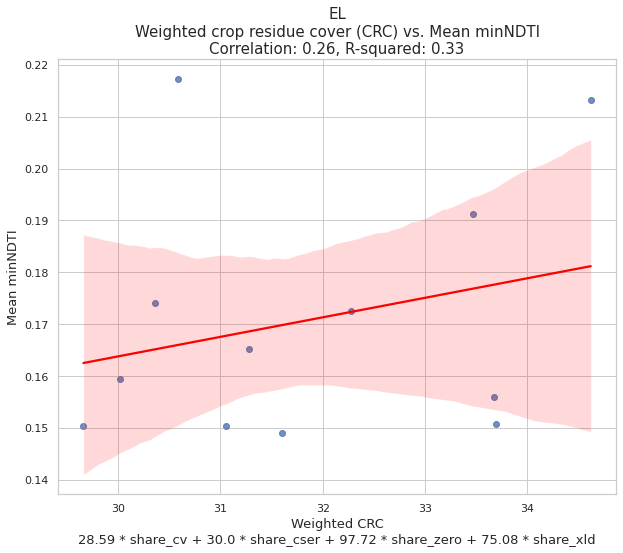

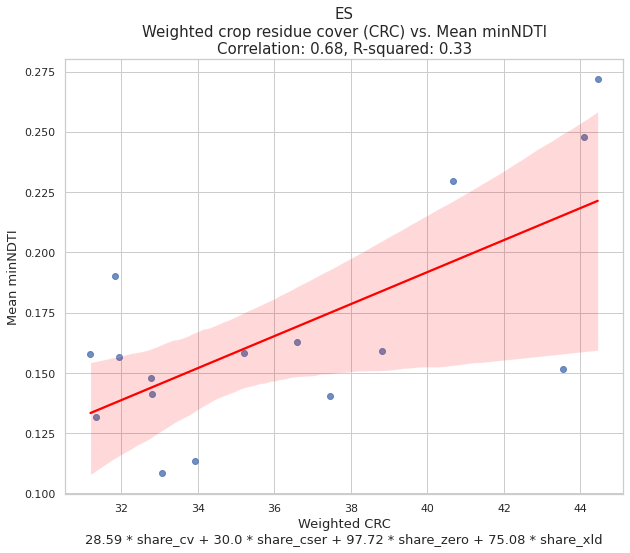

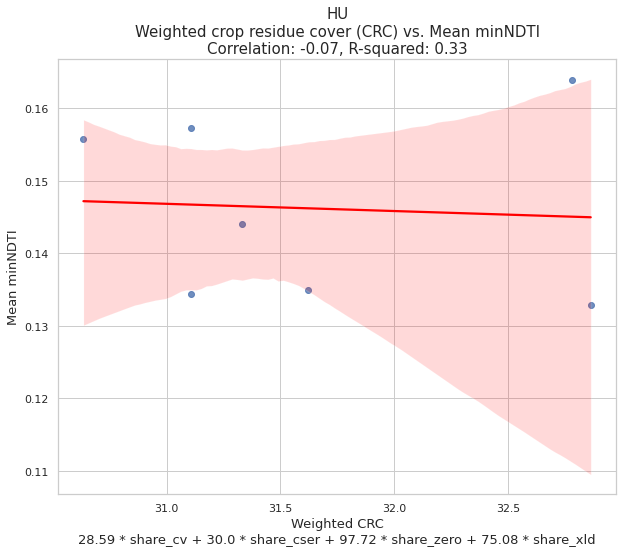

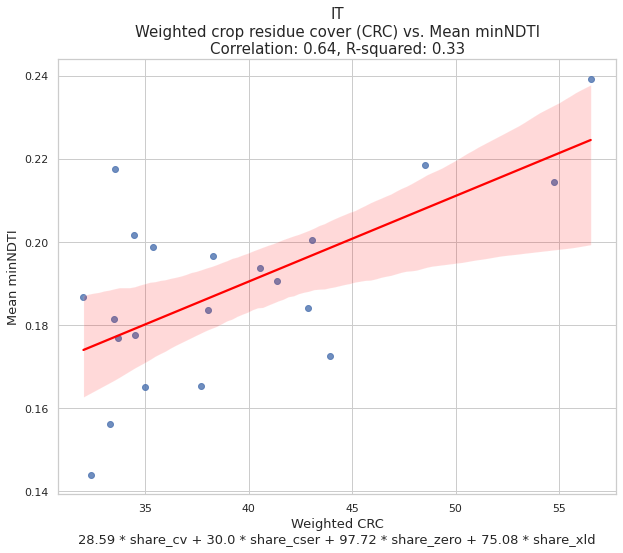

/opt/conda/lib/python3.8/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/conda/lib/python3.8/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


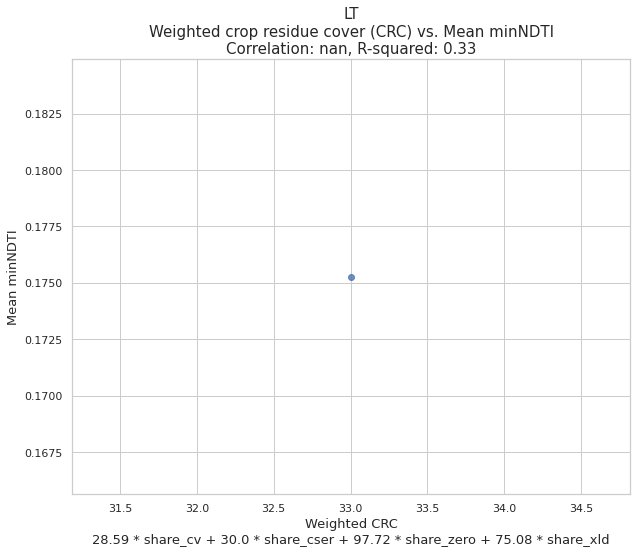

/opt/conda/lib/python3.8/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/conda/lib/python3.8/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


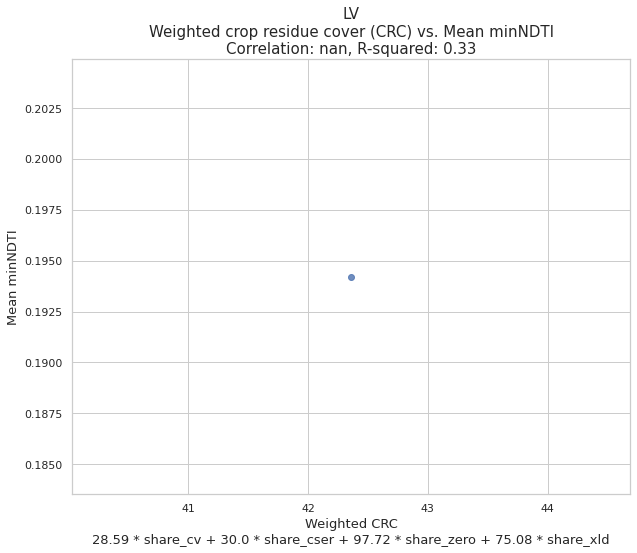

/opt/conda/lib/python3.8/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/conda/lib/python3.8/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


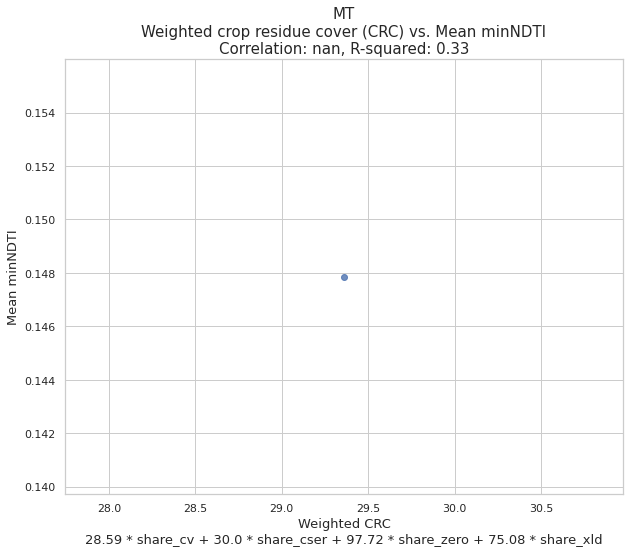

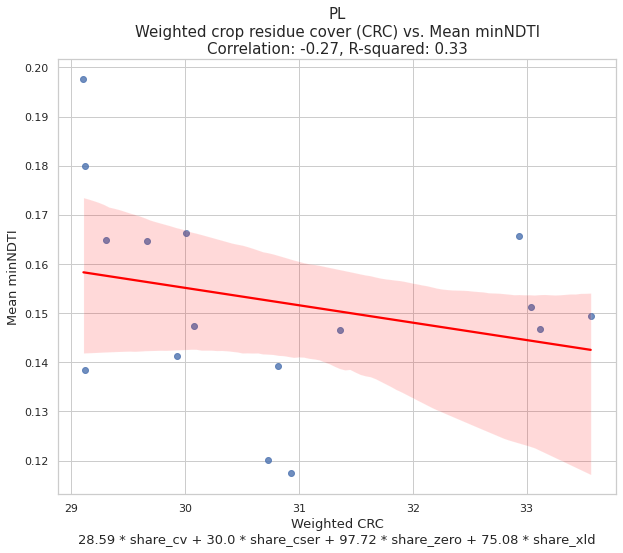

In [27]:
for cntr in tlg['cntr_code'].unique():
    temp = tlg.loc[tlg['cntr_code']==cntr]
    plt.figure(figsize=(10, 8))
    sns.regplot(x='weighted_crc', y='mean_scaled', data=temp, line_kws={"color": "red"})
    correlation_coefficient = temp['mean_scaled'].corr(temp['weighted_crc'])
    # sns.scatterplot(x='weighted_crc', y='mean_scaled', data=tlg, hue='cntr_code', palette='deep')
    # sns.lineplot(x=tlg['weighted_crc'], y=tlg['weighted_crc'] * slope + intercept, color='red')  # Replace 'slope' and 'intercept' with your actual values
    plt.title(f'{cntr}\nWeighted crop residue cover (CRC) vs. Mean minNDTI\nCorrelation: {correlation_coefficient:.2f}, R-squared: {r_squared:.2f}',fontsize=15)
    plt.xlabel('Weighted CRC\n28.59 * share_cv + 30.0 * share_cser + 97.72 * share_zero + 75.08 * share_xld',fontsize=13)
    plt.ylabel('Mean minNDTI',fontsize=13)
    plt.show()

In [9]:
def weighted_score_expression(weights):
    expression = (f"Weighted Score = ({weights[0]} * share_cv) + "
                  f"({weights[1]} * share_cser) + "
                  f"({weights[2]} * share_zero)) " + f"({weights[3]} * share_xld)")  #
    return expression
expression = weighted_score_expression(optimal_weights)
print(expression)

Weighted Score = (28.593359980882873 * share_cv) + (30.0 * share_cser) + (97.82577948900173 * share_zero)) (75.154576576517 * share_xld)


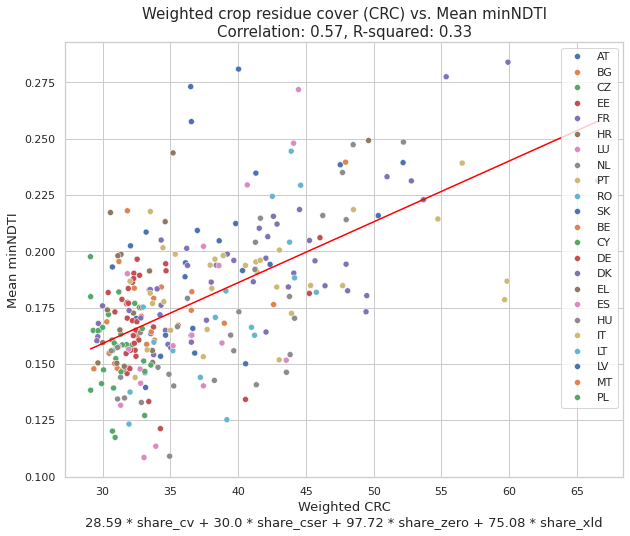

In [21]:
import pandas as pd

climate_zones = {
    'AT': 'Dfb/Dfa', 'BG': 'Dfb/Dfa', 'CZ': 'Dfb/Dfa', 'EE': 'Dfb/Dfa',
    'FR': 'Cfa', 'HR': 'Cfa', 'LU': 'Cfb', 'NL': 'Cfb', 'PT': 'Csa/Csb',
    'RO': 'Dfb/Dfa', 'SK': 'Dfb/Dfa', 'BE': 'Cfb', 'CY': 'Csa/Csb',
    'DE': 'Cfb', 'DK': 'Cfb', 'EL': 'Csa/Csb', 'ES': 'Csa/Csb',
    'HU': 'Dfb/Dfa', 'IT': 'Csa/Csb', 'LT': 'Dfb/Dfa', 'LV': 'Dfb/Dfa',
    'MT': 'Csa/Csb', 'PL': 'Dfb/Dfa'
}

tlg['clm_zone'] = tlg['cntr_code'].map(climate_zones)

plt.figure(figsize=(10, 8))
# sns.regplot(x='weighted_crc', y='mean_scaled', data=tlg, line_kws={"color": "red"})

sns.scatterplot(x='weighted_crc', y='mean_scaled', data=tlg, hue='cntr_code', palette='deep')
sns.lineplot(x=tlg['weighted_crc'], y=tlg['weighted_crc'] * slope + intercept, color='red')  # Replace 'slope' and 'intercept' with your actual values
plt.title(f'Weighted crop residue cover (CRC) vs. Mean minNDTI\nCorrelation: {correlation_coefficient:.2f}, R-squared: {r_squared:.2f}',fontsize=15)
plt.xlabel('Weighted CRC\n28.59 * share_cv + 30.0 * share_cser + 97.72 * share_zero + 75.08 * share_xld',fontsize=13)
plt.ylabel('Mean minNDTI',fontsize=13)
plt.show()

In [15]:
tlgc = pd.DataFrame(columns=['nuts_id','ara', 'araxtil', 'til_cserv', 'til_cv', 'til_zero', 'mean','median', 'p90', 'p10', 
                             'share_xld', 'share_cser','share_cv', 'share_zero', 'mean_scaled'])

for idd in tlg['nuts_id'].unique():
    temp = tlg.loc[tlg['nuts_id']==idd]
    tl = []
    if len(temp)>1:
        temp = temp.sort_values('time')
        tl.append(idd)
        for col in ['ara', 'araxtil', 'til_cserv', 'til_cv', 'til_zero', 'mean','median', 'p90', 'p10', 'share_xld', 'share_cser','share_cv', 'share_zero', 'mean_scaled']:
            tl.append(temp.iloc[1][col]-temp.iloc[0][col])
            
        tlgc.loc[len(tlgc)] = tl
        
tlgc.to_csv(f'/mnt/inca/tillage_index/validate_data/004_vld.change_tillage.csv')        

### farm example

In [38]:
# from shapely.geometry import Point

# farm = pd.read_csv('/mnt/inca/tillage_index/validate_data/bonares_ltfe.csv', delimiter=';')
# geometry = [Point(xy) for xy in zip(farm['longitude'], farm['latitude'])]
# farm = gpd.GeoDataFrame(farm, geometry=geometry, crs='4326')
# farm = farm.to_crs('epsg:3035')

# farm.loc[farm['name']=='LTE Goettingen, Garte-Sued-Bodenbearbeitung (Reinshof)'].to_file('test_farm_point.gpkg',driver='GPKG')
# farm.loc[farm['name']=='LTE Goettingen, Garte-Sued-Bodenbearbeitung (Reinshof)']